In [1]:
import pandas as pd
import numpy as np
import pickle
import pprint
from scipy.stats import kurtosis, skew
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import load_model
from sklearn import metrics
import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
INPUT_DATA = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

TRAINING_SIZE = 1200
TESTING_SIZE = 300

In [3]:
def feature_extraction(x, y, z):
    features = [np.mean(x), np.mean(y), np.mean(z), np.std(x), np.std(y), np.std(z)]
    #Median Absolute Deviation
    features.extend((np.mean(abs(x - features[0])), np.mean(abs(y - features[1])), np.mean(abs(z - features[2]))))
    #Jerk Signals
    features.extend((np.mean(np.diff(x)), np.mean(np.diff(y)), np.mean(np.diff(z)), np.std(np.diff(x)), np.std(np.diff(y)), np.std(np.diff(z))))
    features.extend((np.mean(abs(np.diff(x) - features[9])), np.mean(abs(np.diff(y) - features[10])), np.mean(abs(np.diff(y) - features[11]))))
    features.extend((skew(x), skew(y), skew(z), kurtosis(x), kurtosis(y), kurtosis(z)))
    features.extend((max(x), max(y), max(z), min(x), min(y), min(z)))
    return features

def add_noise(data):
    data_noise = data + np.random.uniform(size=len(data))
    data_noise = data_noise + np.random.laplace(loc=0.0, scale=1.0, size=len(data))
    return data_noise

def data_augmentation(X):
    X_noise = X
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            X_noise[i][:][j] = add_noise(X_noise[i][:][j])
    return np.concatenate((X, X_noise), axis=0)

def feature_selection(X, augmentData=False):
    data = []
    for i in range(X.shape[0]):
        features = []
        for j in range(0, X.shape[2], 3):
            x = [X[i][u][j] for u in range(X.shape[1])]
            y = [X[i][u][j+1] for u in range(X.shape[1])]
            z = [X[i][u][j+2] for u in range(X.shape[1])]
            
            if augmentData:
                x_noise = add_noise(x)
                y_noise = add_noise(y)
                z_noise = add_noise(z)
                features.append(feature_extraction(x_noise, y_noise, z_noise))
            else:
                features.append(feature_extraction(x, y, z))

        data.append(features)
    return np.array(data)

def feature_engineering(X, augmentData=False):
    if augmentData:
        return np.concatenate((feature_selection(X, False), feature_selection(X, True)), axis=0)
    else:
        return feature_selection(X, False)
    
def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in 
             [row.replace('  ', ' ').strip().split(' ') for row in file]
            ]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))


def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_ - 1

In [4]:

X_train_input_paths = ["data/train/" + signal + "train.txt" for signal in INPUT_DATA]
X_test_input_paths = ["data/test/" + signal + "test.txt" for signal in INPUT_DATA]
X_train = load_X(X_train_input_paths)
X_test = load_X(X_test_input_paths)

y_train_path = "data/y_train.txt"
y_test_path = "data/y_test.txt"
Y_train = load_y(y_train_path).ravel()
Y_test = load_y(y_test_path).ravel()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

print(X_train[0])
print(Y_train[0])

X_train = X_train[0:TRAINING_SIZE]
Y_train = Y_train[0:TRAINING_SIZE]
X_test = X_test[0:TESTING_SIZE]
Y_test = Y_test[0:TESTING_SIZE]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(7352, 128, 9)
(7352,)
(2947, 128, 9)
(2947,)
[[  1.80851493e-04   1.07668098e-02   5.55606782e-02 ...,   1.01281703e+00
   -1.23216704e-01   1.02934100e-01]
 [  1.01385601e-02   6.57948013e-03   5.51248305e-02 ...,   1.02283299e+00
   -1.26875594e-01   1.05687201e-01]
 [  9.27557424e-03   8.92887823e-03   4.84047309e-02 ...,   1.02202797e+00
   -1.24003701e-01   1.02102503e-01]
 ..., 
 [ -1.14748406e-03   1.71443899e-04   2.64786393e-03 ...,   1.01844501e+00
   -1.24069601e-01   1.00385197e-01]
 [ -2.22265502e-04   1.57418102e-03   2.38105701e-03 ...,   1.01937199e+00
   -1.22745097e-01   9.98735502e-02]
 [  1.57550001e-03   3.07018892e-03  -2.26975698e-03 ...,   1.02117097e+00
   -1.21325999e-01   9.49874073e-02]]
4
(1200, 128, 9)
(1200,)
(300, 128, 9)
(300,)


In [5]:
#Raw Data
X = X_train
Xt = X_test
Y = Y_train
Yt = Y_test

#Raw Data with Data Augmentation
X = data_augmentation(X)
Xt = data_augmentation(Xt)
Y = np.concatenate((Y_train, Y_train), axis=0)
Yt = np.concatenate((Y_test, Y_test), axis=0)

#Feature Selection & Data Augmentation
'''
X = feature_engineering(X_train, True)
Xt = feature_engineering(X_test, True)
Y = np.concatenate((Y_train, Y_train), axis=0)
Yt = np.concatenate((Y_test, Y_test), axis=0)
'''




Yhot = to_categorical(Y)

print(X.shape)
print(Xt.shape)
print(Yhot.shape)
print(X[0])

np.savetxt("data/test_data_format.csv", Xt[0], delimiter=",")

#X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
#Xt = Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2])

print(X.shape)
print(Xt.shape)


(2400, 128, 9)
(600, 128, 9)
(2400, 6)
[[  1.81108439e+00  -1.02301610e+00   1.39250767e+00 ...,   1.53240073e+00
    6.32285923e-02   9.05288607e-02]
 [  1.88964331e+00   1.57726634e+00   1.94999647e+00 ...,   8.03351164e-01
    1.14505783e-01   2.02240849e+00]
 [  2.48990226e+00   5.08842707e+00  -1.23799458e-01 ...,   2.32411265e+00
    3.03197193e+00   9.88953710e-01]
 ..., 
 [ -1.14748406e-03   1.71443899e-04   2.64786393e-03 ...,   1.01844501e+00
   -1.24069601e-01   1.00385197e-01]
 [ -2.22265502e-04   1.57418102e-03   2.38105701e-03 ...,   1.01937199e+00
   -1.22745097e-01   9.98735502e-02]
 [  1.57550001e-03   3.07018892e-03  -2.26975698e-03 ...,   1.02117097e+00
   -1.21325999e-01   9.49874073e-02]]
(2400, 128, 9)
(600, 128, 9)


In [6]:
#Neural Network

data_dim = X.shape[2]
timesteps = X.shape[1]
num_classes = Yhot.shape[1]
b_size = 32

model = Sequential()
model.add(LSTM(16, return_sequences=True, input_shape=(timesteps, data_dim)))
model.add(LSTM(16, return_sequences=True))
#model.add(LSTM(16, return_sequences=True))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Yhot, epochs=30, batch_size=b_size, validation_split=0.2, shuffle=True)
result = model.evaluate(X, Yhot)
print("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))


Train on 1920 samples, validate on 480 samples
Epoch 1/30
1920/1920 [==============================] - 35s - loss: 1.1535 - acc: 0.4995 - val_loss: 1.2141 - val_acc: 0.4146
Epoch 2/30
1920/1920 [==============================] - 38s - loss: 0.7294 - acc: 0.6849 - val_loss: 0.8290 - val_acc: 0.6250
Epoch 3/30
1920/1920 [==============================] - 35s - loss: 0.4585 - acc: 0.8193 - val_loss: 0.4726 - val_acc: 0.7812
Epoch 4/30
1920/1920 [==============================] - 36s - loss: 0.1997 - acc: 0.9271 - val_loss: 0.2436 - val_acc: 0.9125
Epoch 5/30
1920/1920 [==============================] - 36s - loss: 0.1213 - acc: 0.9552 - val_loss: 0.1689 - val_acc: 0.9167
Epoch 6/30
1920/1920 [==============================] - 35s - loss: 0.0783 - acc: 0.9760 - val_loss: 0.1346 - val_acc: 0.9292
Epoch 7/30
1920/1920 [==============================] - 36s - loss: 0.0644 - acc: 0.9755 - val_loss: 0.1248 - val_acc: 0.9354
Epoch 8/30
1920/1920 [==============================] - 35s - loss: 0.0

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 4 0 0 0 0 0 0 4 4 4 4 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 0 0 1 1 1 1 1 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4
 4 4 3 4 3 3 3 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 4 1 1 1
 2 1 1 2 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 4 0 0 0 0 0 0 4 4 4 4 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 0 0 1 1 1 1 1 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 3 3 4 4 4 3 4 3 3 3 4 

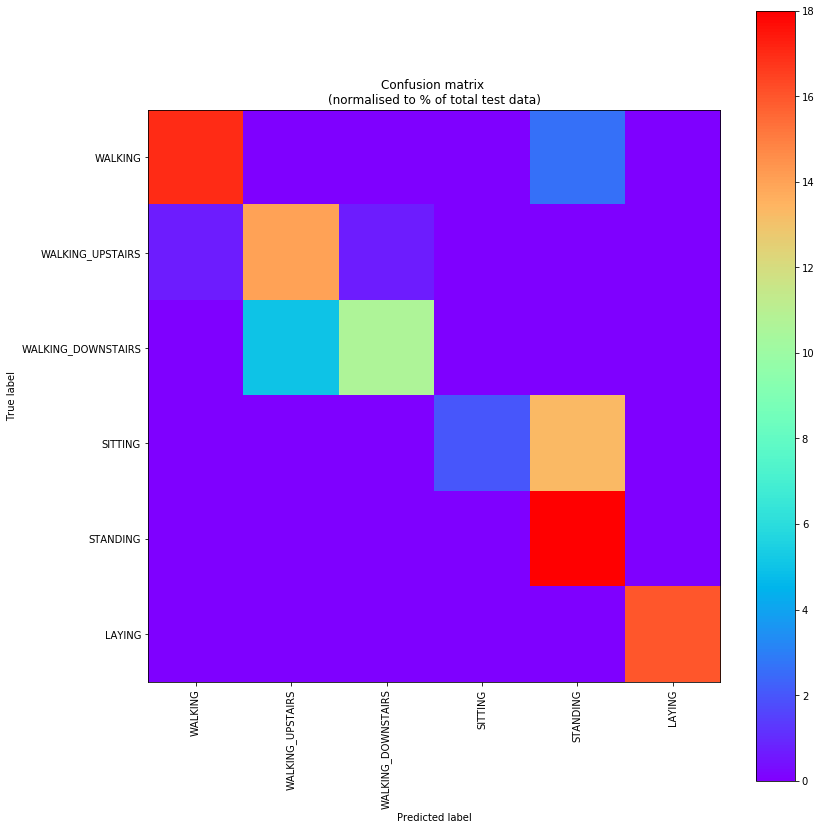

In [10]:
Y_output = model.predict(Xt)
Y_pred = np.argmax(Y_output, axis=1)
print(np.array(Y_pred))
print("Accuracy Rate:")
print(metrics.accuracy_score(Yt, Y_pred))
print(metrics.confusion_matrix(Yt, Y_pred))

print("Precision: {}%".format(100*metrics.precision_score(Yt, Y_pred, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Yt, Y_pred, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Yt, Y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Yt, Y_pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

np.savetxt("data/accuracy.csv", [metrics.accuracy_score(Yt, Y_pred)], delimiter=",")
np.savetxt("data/confusion_matrix.csv", metrics.confusion_matrix(Yt, Y_pred), delimiter=",")


In [8]:
model.save('data/har_rnn_lstm.h5')  # creates a HDF5 file 'my_model.h5'

In [9]:
raw_data = pd.read_csv('data/sample_data_format.csv', skiprows=range(0, 7))
print(raw_data.shape)
cropped_data = raw_data.values.reshape(-1, 40, 9)
print(cropped_data.shape)
print(cropped_data)
pickle.dump(cropped_data, open('data/cropped_data_format.pkl', 'wb'))
np.savetxt("data/cropped_data_format_2.csv", cropped_data[2], delimiter=",")


(120, 9)
(3, 40, 9)
[[[  3.30674392e-03   4.08453215e-03   3.11877709e-02 ...,   1.01641703e+00
    -1.25868201e-01   1.02473199e-01]
  [  7.57194078e-03   5.11844782e-03   2.35671904e-02 ...,   1.02074504e+00
    -1.24368198e-01   9.75658968e-02]
  [  5.40711684e-03   5.89226792e-03   2.10004691e-02 ...,   1.01864302e+00
    -1.23138197e-01   9.76466537e-02]
  ..., 
  [  2.28138897e-03  -4.51477198e-03  -2.35145297e-02 ...,   1.01842904e+00
    -1.24303102e-01   1.02193497e-01]
  [  3.65372794e-03  -5.92592312e-03  -1.84824299e-02 ...,   1.01989496e+00
    -1.25629902e-01   1.07519001e-01]
  [  2.31263903e-03  -5.06280502e-03  -1.73001904e-02 ...,   1.01864696e+00
    -1.24689601e-01   1.08948000e-01]]

 [[ -4.04219390e-05  -2.24447693e-03  -1.92251801e-02 ...,   1.01638699e+00
    -1.21801399e-01   1.07225001e-01]
  [  5.34225372e-04  -7.86087825e-04  -2.20926702e-02 ...,   1.01705301e+00
    -1.20280102e-01   1.04516402e-01]
  [  2.96326308e-03  -1.21828204e-03  -2.44254097e-02 ...,